In [29]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.chdir("/kaggle/input/eegdata")

/kaggle/input/eegdata/y_test.npy
/kaggle/input/eegdata/main.py
/kaggle/input/eegdata/y_train_valid.npy
/kaggle/input/eegdata/person_train_valid.npy
/kaggle/input/eegdata/EEG_pl.py
/kaggle/input/eegdata/X_test.npy
/kaggle/input/eegdata/dataset.py
/kaggle/input/eegdata/EEG_loading.ipynb
/kaggle/input/eegdata/person_test.npy
/kaggle/input/eegdata/X_train_valid.npy
/kaggle/input/eegdata/classifier.py


In [30]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, CuDNNGRU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers
from keras.callbacks import EarlyStopping

In [31]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [32]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left is 769 - 0
# Cue onset right is 770 - 1
# Cue onset foot is 771 - 2
# Cue onset tongue is 772 - 3

y_train_valid -= 769
y_test -= 769

In [33]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 1000, 1)
Shape of validation set after adding width info: (500, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (1615, 1000, 1, 22)
Shape of validation set after dimension reshaping: (500, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


In [34]:
# Building the CNN model using sequential class
hybrid_cnn_gru_model = Sequential()

# Conv. block 1
hybrid_cnn_gru_model.add(Conv2D(filters=16, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22), kernel_regularizer=regularizers.l2(0.01)))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_gru_model.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_gru_model.add(Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_gru_model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# FC+GRU layers
hybrid_cnn_gru_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_gru_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_gru_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_gru_model.add(CuDNNGRU(10, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_gru_model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1000, 1, 16)       3536      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 334, 1, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 334, 1, 16)        64        
_________________________________________________________________
dropout_12 (Dropout)         (None, 334, 1, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 334, 1, 32)        5152      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 1, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 1, 32)       

In [35]:
from tensorflow.keras.optimizers import Adam

learning_rate = 5e-4
epochs = 200
hybrid_cnn_gru_optimizer = Adam(learning_rate=learning_rate)

In [36]:
# Compiling the model
hybrid_cnn_gru_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_gru_optimizer,
                 metrics=['accuracy'])

#callbacks = [EarlyStopping(monitor='val_accuracy', patience=25)]

# Training and validating the model
hybrid_cnn_gru_model_results = hybrid_cnn_gru_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             #callbacks=callbacks,                                             
             verbose=True)

Epoch 1/200
26/26 [==============================] - 2s 29ms/step - loss: 3.0857 - accuracy: 0.2743 - val_loss: 2.9674 - val_accuracy: 0.3180
Epoch 2/200
26/26 [==============================] - 0s 14ms/step - loss: 2.9315 - accuracy: 0.2793 - val_loss: 2.8246 - val_accuracy: 0.3720
Epoch 3/200
26/26 [==============================] - 0s 14ms/step - loss: 2.7713 - accuracy: 0.3176 - val_loss: 2.6869 - val_accuracy: 0.3580
Epoch 4/200
26/26 [==============================] - 0s 14ms/step - loss: 2.6489 - accuracy: 0.3183 - val_loss: 2.5709 - val_accuracy: 0.3500
Epoch 5/200
26/26 [==============================] - 0s 14ms/step - loss: 2.5170 - accuracy: 0.3474 - val_loss: 2.4606 - val_accuracy: 0.3320
Epoch 6/200
26/26 [==============================] - 0s 14ms/step - loss: 2.4134 - accuracy: 0.3536 - val_loss: 2.3521 - val_accuracy: 0.3640
Epoch 7/200
26/26 [==============================] - 0s 14ms/step - loss: 2.2952 - accuracy: 0.3672 - val_loss: 2.2582 - val_accuracy: 0.3580
Epoch 

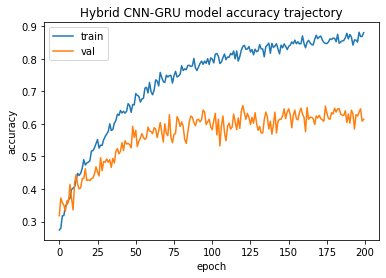

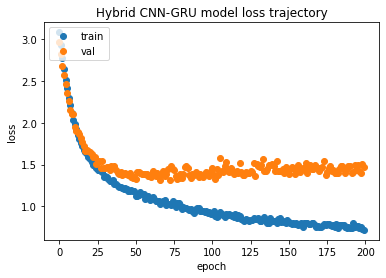

In [40]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_gru_model_results.history['accuracy'])
plt.plot(hybrid_cnn_gru_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_gru_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_gru_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
## Testing the hybrid CNN-GRU model

hybrid_cnn_gru_score = hybrid_cnn_gru_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-GRU model:',hybrid_cnn_gru_score[1])

Test accuracy of the hybrid CNN-GRU model: 0.6252821683883667


In [42]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_pred_test = hybrid_cnn_gru_model.predict(x_test)


# classification_report
for i,x in enumerate(['left','right','foot','tongue']):
    print(x)
    y_pred = np.where(y_pred_test[:,i]>0.5,1,0)
    
    print(classification_report(y_test[:,i], y_pred))

left
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       332
         1.0       0.66      0.51      0.58       111

    accuracy                           0.81       443
   macro avg       0.76      0.71      0.73       443
weighted avg       0.80      0.81      0.80       443

right
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81       316
         1.0       0.54      0.72      0.62       127

    accuracy                           0.74       443
   macro avg       0.71      0.74      0.71       443
weighted avg       0.78      0.74      0.75       443

foot
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91       347
         1.0       0.70      0.51      0.59        96

    accuracy                           0.85       443
   macro avg       0.79      0.72      0.75       443
weighted avg       0.84      0.85      0.84       443

ton